In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
import matplotlib.pyplot as plt
import numpy as np
from epi.models import Parameter, Model
from epi.util import pairplot
import tensorflow as tf
from epi.SC_Circuit_4 import SC_acc, SC_acc_diff, \
    SC_acc_var, SC_sim, \
    SC_sim_opto, unwrap, \
    get_schur_eigs
from scipy.special import expit
from sklearn.linear_model import LinearRegression
import scipy.stats

import os
figdir = "../../written/eLifeRevision/figures/fig3/"

c_LP = '#3B8023'
c_LA = '#EA8E4C'
c_RA = '#F4C673'
c_RP = '#81C176'

num_plot = 500

### 1. Define the V1Circuit model

In [2]:
lb = -5.
ub = 5.

sW = Parameter("sW", 1, lb=lb, ub=ub)
vW = Parameter("vW", 1, lb=lb, ub=ub)
dW = Parameter("dW", 1, lb=lb, ub=ub)
hW = Parameter("hW", 1, lb=lb, ub=ub)

parameters = [sW, vW, dW, hW]

model = Model("SC_Circuit_var", parameters)

In [3]:
p = 0.75
mu_std = 0.05
model.set_eps(SC_acc_var(p))

epi_df = model.get_epi_df()
epi_df['c0'] = [al_hps['c0'] for al_hps in epi_df['AL_hps']]
epi_df['beta'] = [al_hps['beta'] for al_hps in epi_df['AL_hps']]
epi_df['elemwise_fn'] = ['affine' if 'affine' in path else 'spline' for path in epi_df['path']]
epi_df['random_seed'] = [al_hps['random_seed'] for al_hps in epi_df['arch']]
epi_df['bnmom'] = [al_hps['bn_momentum'] for al_hps in epi_df['arch']]
epi_df['p'] = [ep['mu'][0] for ep in epi_df['EP']]
epi_df['mu_std'] = [np.sqrt(ep['mu'][2]) for ep in epi_df['EP']]
epi_df['mu_len'] = [ep['mu'].shape[0] for ep in epi_df['EP']]

data/epi/SC_Circuit_var/a2c18082e7d1e33948198182605af211/D4_C3_affine_L2_U50_rs9/fdaf5b31967f59138c9b4e2ff6a1bec4/N100_lr1.00E-03_c0=1.00E+02_gamma2.50E-01_beta4.00E+00
mu std 0.05
beta 4.0
random seed 9


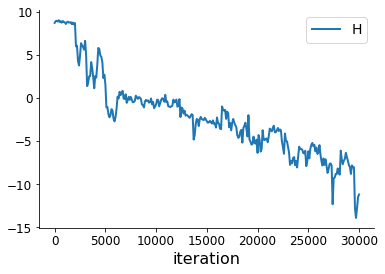

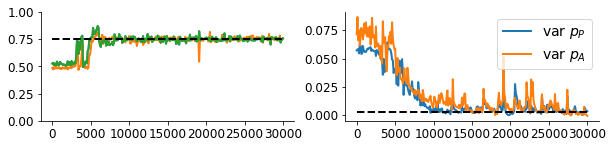

In [155]:
mu =  np.array([p, 1-p, mu_std**2, mu_std**2])
epi_df2 = epi_df[(epi_df['p']==p)
               & (epi_df['elemwise_fn']=="affine")
               & (epi_df['beta']==4.)
               & (epi_df['random_seed'] ==9)]
               #& (epi_df['c0']==1e2) 
               #& (epi_df['mu_std']==mu_std) 
               #& (epi_df['mu_len'] == 4)]


paths = sorted(epi_df2['path'].unique())
for i, path in enumerate(paths):
    print(path)
    epi_df2 = epi_df[epi_df['path'] == path]
    print('mu std', epi_df2['mu_std'].iloc[0])
    print('beta', epi_df2['beta'].iloc[0])
    print('random seed', epi_df2['random_seed'].iloc[0])
    epi_df2.plot('iteration', 'H')
    plt.show()
    fig, axs = plt.subplots(1,2,figsize=(10,2))
    Rs = ['R%d' % r for r in range(1,3)]
    axs[0].plot(epi_df2['iteration'], epi_df2['R1'] + mu[0], label=r'$p_P$')
    axs[0].plot(epi_df2['iteration'], 1.-(epi_df2['R2'] + mu[1]), label=r'$p_A$')
    axs[0].plot(epi_df2['iteration'], epi_df2['R1'] + mu[0], label=r'$p_P$')
    axs[0].plot([0, epi_df2['iteration'].max()], [mu[0], mu[0]], 'k--')
    axs[0].set_ylim([0,1])
    axs[1].plot(epi_df2['iteration'], epi_df2['R3'], label=r'var $p_P$')
    axs[1].plot(epi_df2['iteration'], epi_df2['R4'], label=r'var $p_A$')
    axs[1].plot([epi_df2['iteration'].min(), epi_df2['iteration'].max()], [mu_std**2, mu_std**2], 'k--')
    plt.legend()
    plt.show()

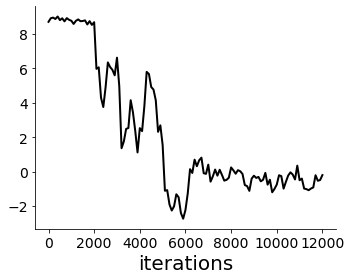

0 -
1 -
2 --
3 --


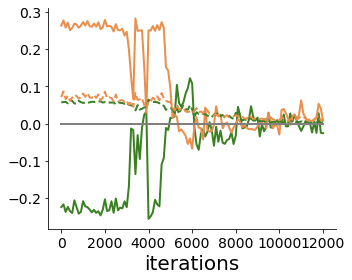

In [156]:
from epi.util import plot_opt

opt_figdir = "../../written/eLifeRevision/figures/figSC5/"
cs = [c_LP, c_LA]
for path in paths:
    _epi_df = epi_df[epi_df['path'] == path]
    plot_opt(_epi_df, max_k=6, cs=cs, fontsize=20, figdir=opt_figdir, save=True)


In [157]:
best_Hs = []
convergeds = []
best_ks = []
nu = 0.5
for i, path in enumerate(paths):
    _epi_df = epi_df[epi_df['path'] == path]
    df_row = _epi_df.iloc[0]
    init = df_row['init']
    init_params = {"mu":init["mu"], "Sigma":init["Sigma"]}
    nf = model._df_row_to_nf(df_row)
    aug_lag_hps = model._df_row_to_al_hps(df_row)
    best_k, converged, best_H = model.get_convergence_epoch(init_params, nf, mu, aug_lag_hps, 
                                    alpha=0.05, nu=nu)
    best_Hs.append(best_H)
    convergeds.append(converged)
    best_ks.append(best_k)


bestHs = np.array(best_Hs)
best_ks = np.array(best_ks)

best_Hs = np.array([x if x is not None else np.nan for x in best_Hs])
ind = np.nanargmax(best_Hs)

path = paths[ind]
best_k = int(best_ks[ind])
best_H = best_Hs[ind]

/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


KeyboardInterrupt: 

In [158]:
best_k = 13
path = paths[0]
_epi_df = epi_df[epi_df['path'] == path]
df_row = _epi_df.iloc[0]
init = df_row['init']
init_params = {"mu":init["mu"], "Sigma":init["Sigma"]}
nf = model._df_row_to_nf(df_row)
aug_lag_hps = model._df_row_to_al_hps(df_row)

dist = model._get_epi_dist(best_k, init_params, nf, mu, aug_lag_hps)

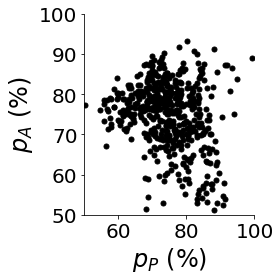

In [159]:
np.random.seed(0)
tf.random.set_seed(0)
z, log_q_z = dist.nf(500)
z = z.numpy()
log_q_z = log_q_z.numpy()
T_x = model.eps(z).numpy()
#u_t, v_t = SC_sim(*unwrap(z))
#T_x = np.mean(expit(100.*(v_t[-1,:,:,0,:] - v_t[-1,:,:,3,:])), axis=2)
fig, ax = plt.subplots(1,1,figsize=(4,4))
plt.scatter(100*(T_x[:num_plot,0]), 100.*(1-T_x[:num_plot,1]), s=25, c='k')
ax.plot([0,1], [0,1], 'k-')
plt.xlabel(r'$p_P$ (%)', fontsize=24)
plt.ylabel(r'$p_A$ (%)', fontsize=24)
plt.xlim([50, 100])
plt.ylim([50, 100])
plt.setp(ax.get_xticklabels(), fontsize=20)
plt.setp(ax.get_yticklabels(), fontsize=20)
plt.tight_layout()
#plt.savefig(os.path.join(figdir, "SC_T_x.pdf"))



In [160]:
m, b, r, pval, _ = scipy.stats.linregress(T_x[:,0], 1.-T_x[:,1])
print(m, b, r, pval)

-0.2637339137263005 0.9459557144233909 -0.25571267181986207 6.619335231179153e-09


In [161]:
_lb = np.array([p.lb[0] for p in model.parameters])
_ub = np.array([p.ub[0] for p in model.parameters])
z_labels = [p.name for p in model.parameters]
#plot_inds = np.logical_and(z[:,0] < 5., z[:,1] < 5.)
plot_inds = z[:,3] < 6. # keep all
#    np.logical_and(z[:,0] < 1., z[:,1] < 0.), 
#    np.logical_and(z[:,2] < 0., z[:,3] < -1.25))
#plot_inds = np.logical_and(plot_inds, z[:,3]  > -2.)
z_plot = z[plot_inds]
log_q_z_plot = log_q_z[plot_inds]
#v_t_plot = v_t.numpy()[:,plot_inds]
#u_t_plot = u_t.numpy()[:,plot_inds]
T_x_plot = T_x[plot_inds]

p_stars = [0.75]
z_stars = []
z_star_inds = []
for p_star in p_stars:
    mu_star = np.array([p_star, 1.-p_star])[None,:]
    d = np.linalg.norm(T_x_plot[:,:2]-mu_star, axis=1)
    #d = np.square(T_x_plot[:,1]-(1.-p_star))
    min_ind = np.argmin(d)
    print(T_x_plot[min_ind,:2])
    z_stars.append(z_plot[min_ind,:])
    z_star_inds.append(min_ind)
z_stars = np.array(z_stars)
alpha_c_star = 1.
#c_stars = [np.concatenate((np.array([0,0,0]), np.array([alpha_c_star]))),
#             np.concatenate((.7*np.ones((3,)), np.array([alpha_c_star])))]
c_stars = ['k']
cmap_g = plt.get_cmap('Greens')
cmap_o = plt.get_cmap('Oranges')


[0.74565095 0.24846701]


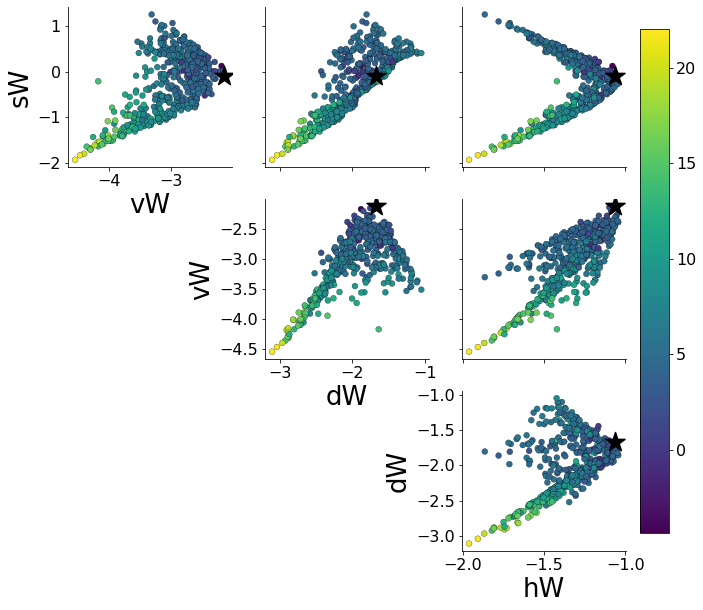

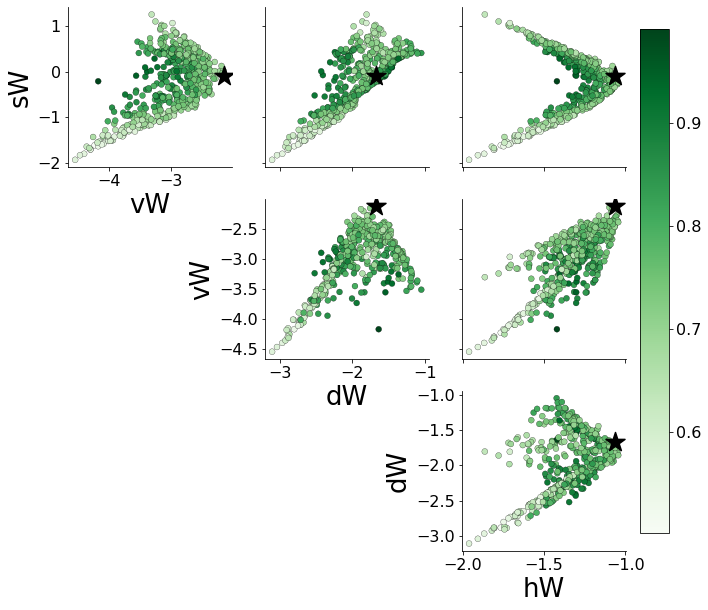

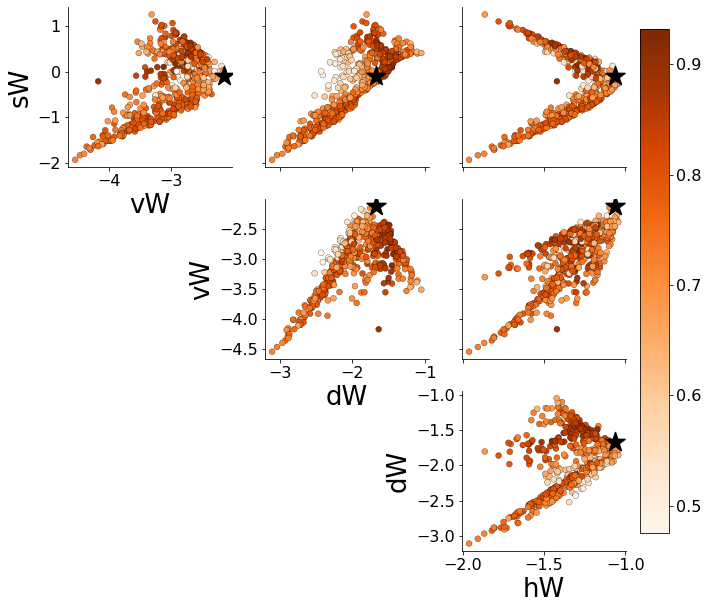

In [162]:
fig = pairplot(z_plot[:num_plot], np.arange(4), z_labels, starred=z_stars, c_starred=c_stars, 
               fontsize=26, figsize=(10,10), ticksize=16, s=35,
               c=log_q_z_plot[:num_plot])
#plt.savefig(os.path.join(figdir, "SC_EPI_logqz.png"), dpi=600, transparent=True)

fig = pairplot(z_plot[:num_plot], np.arange(4), z_labels, starred=z_stars, c_starred=c_stars, 
               fontsize=26, figsize=(10,10), ticksize=16, s=35,
               c=T_x_plot[:num_plot,0], cmap=cmap_g)
fig = pairplot(z_plot[:num_plot], np.arange(4), z_labels, starred=z_stars, c_starred=c_stars, 
               fontsize=26, figsize=(10,10), ticksize=16, s=35,
               c=(1.-T_x_plot[:num_plot,1]), cmap=cmap_o)

In [119]:
v_t_stars = np.stack([v_t_plot[:,ind,:,:,:] for ind in z_star_inds], axis=1)
T_x_stars = np.stack([T_x_plot[ind,:] for ind in z_star_inds], axis=0)

t_cue_delay = 1.2
t_choice = 0.3
t_post_choice = 0.3
t_total = t_cue_delay + t_choice + t_post_choice
dt = 0.024
t = np.arange(0.0, t_total, dt)
T = t.shape[0]

percfont = {'family': 'arial',
            'weight': 'light',
            'size': 20,
        }
neuron_labels = ['LP', 'LA', 'RA', 'RP']
colors = [c_LP, c_LA, c_RA, c_RP]
C_titles = ['Pro, left trials', 'Anti, left trials']
for m in range(len(z_stars)):
    print("%.1f, %.1f" % (100*T_x_stars[m,0], 100-100*T_x_stars[m,1]))
    fig, axs = plt.subplots(1,2,figsize=(8, 3))
    for c in range(2):
        for i in range(4):
            mean_v = np.mean(v_t_stars[:,m,c,i,:], axis=1)
            std_v = np.std(v_t_stars[:,m,c,i,:], axis=1)
            axs[c].fill_between(t, mean_v - std_v, mean_v + std_v, color=colors[i], alpha=0.2)
            axs[c].plot(t, mean_v, label=neuron_labels[i], c=colors[i])
            axs[c].set_title(C_titles[c])
            axs[c].set_ylim([0,1])
            if c == 0:
                axs[c].text(0.75, 0.5, '%2d%%' % round(100.*T_x_stars[m,c]), fontdict=percfont)
            else:
                axs[c].text(0.75, 0.5, '%2d%%' % round(100.*(1.-T_x_stars[m,c])), fontdict=percfont)
        axs[c].set_xlabel('time (s)')
    axs[0].set_ylabel('Activation')
        
    plt.tight_layout()
    plt.savefig(os.path.join(figdir, "sim%d.pdf" % (m+1)))
    plt.show()

NameError: name 'v_t_plot' is not defined

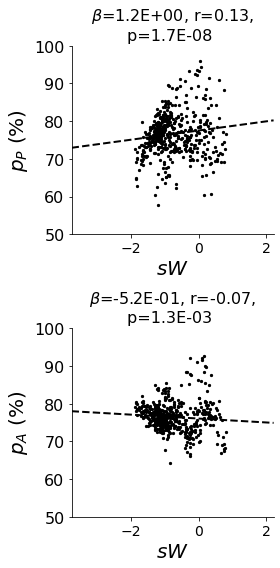

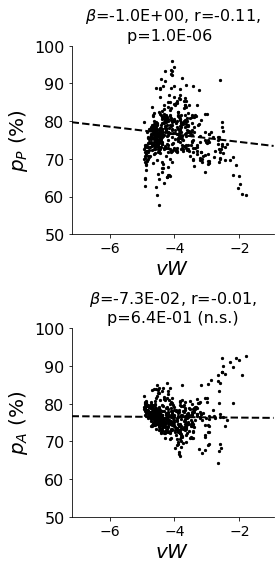

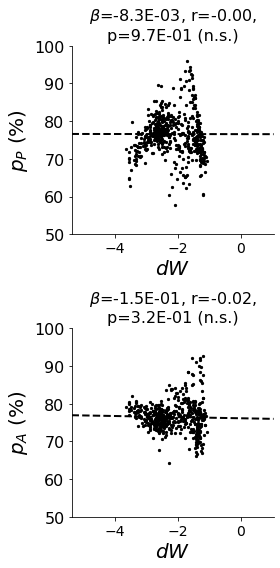

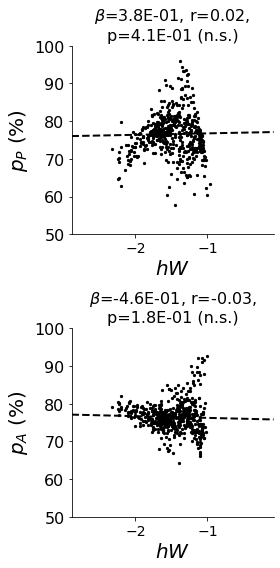

In [17]:
T_x_plot = SC_acc(*unwrap(z_plot))

T_x_plot = T_x_plot.numpy()
sW = z_plot[:,0]
vW = z_plot[:,1]
dW = z_plot[:,2]
hW = z_plot[:,3]
pP = T_x_plot[:,0]
pA = 1. - T_x_plot[:,1]

ylabels = [r'$p_P$ (%)', r'$p_A$ (%)']

def plot_2corrs(x, xlabel, y1, y2, ylabels, ylims=None, alignment='h', 
                 s=10, num_plot=None, c=None, fontsize=20):
    x_mean, x_std = np.mean(x) ,np.std(x)
    ys = [y1, y2]
    lin_models = [scipy.stats.linregress(x, y) for y in ys]
    if c is None:
        c = 'k'
    xticksize = fontsize-6
    yticksize = fontsize-4
    titlesize = fontsize-4
    if alignment == 'h':
        fig, axs = plt.subplots(1,2,figsize=(10,4))
    elif alignment == 'v':
        fig, axs = plt.subplots(2,1,figsize=(4,8))
    else:
        return None
    
    x = x[:num_plot]
    y1 = y1[:num_plot]
    y2 = y2[:num_plot]
    
    axs[0].scatter(x, y1, s=s, c=c)
    axs[0].set_xlabel(xlabel, fontsize=fontsize)
    axs[0].set_ylabel(ylabels[0], fontsize=fontsize)
    plt.setp(axs[0].get_xticklabels(), fontsize=xticksize)
    plt.setp(axs[0].get_yticklabels(), fontsize=yticksize)
    axs[1].scatter(x, y2, s=s, c=c)
    axs[1].set_xlabel(xlabel, fontsize=fontsize)
    axs[1].set_ylabel(ylabels[1], fontsize=fontsize)
    plt.setp(axs[1].get_xticklabels(), fontsize=xticksize)
    plt.setp(axs[1].get_yticklabels(), fontsize=yticksize)
    
    for i, y in enumerate(ys):
        x1, x2 = x_mean-5*x_std, x_mean+5*x_std
        axs[i].set_xlim([x1, x2])
        m, b, r, pval, _ = lin_models[i]
        axs[i].plot([x1, x2], [b + m*x1, b+m*x2], 'k--')
        if pval < 0.05:
            pval_str = ""
        else:
            pval_str = "(n.s.)"
        metric_str = (r"$\beta$=%.1E, r=%.2f," "\n" "p=%.1E %s") % (m,r,pval,pval_str)
        axs[i].set_title(metric_str, fontsize=titlesize)
        if ylims is not None:
            axs[i].set_ylim(ylims)
        
    return None

xs = [sW, vW, dW, hW]
xlabels = [r'$sW$', r'$vW$', r'$dW$', r'$hW$']

for i, (x, xlabel) in enumerate(zip(xs, xlabels)):
    plot_2corrs(x, xlabel, 100*pP, 100*pA, ylabels, ylims = [50, 100],
                 alignment='v', s=5, num_plot=500)
    plt.tight_layout()
    plt.savefig(os.path.join(figdir, "%s_corr.pdf" % xlabel), transparent=True)
    plt.show()

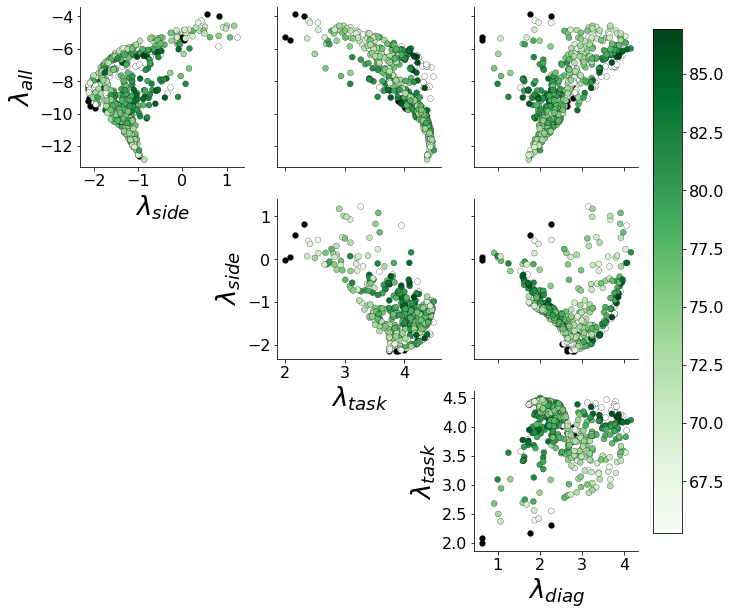

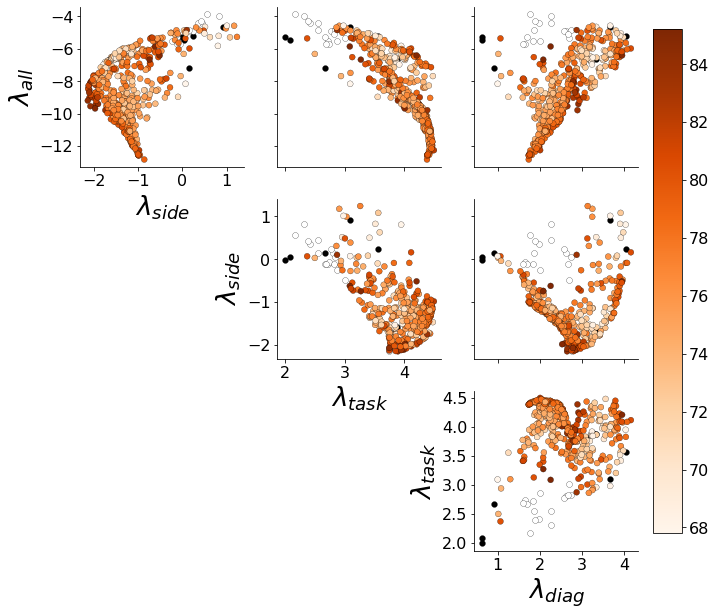

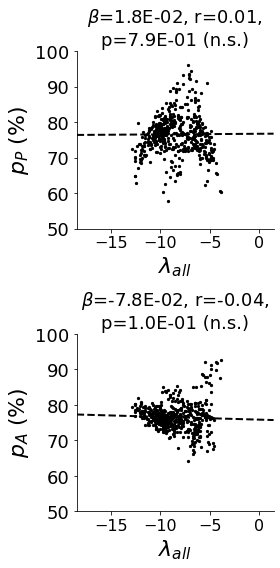

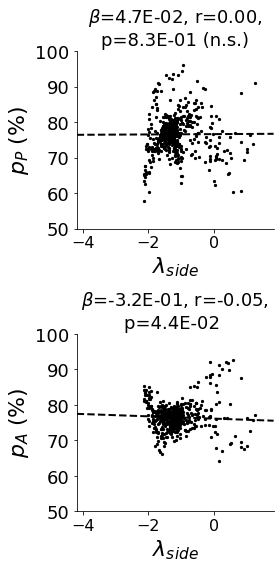

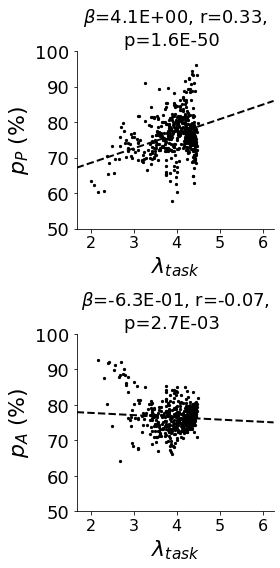

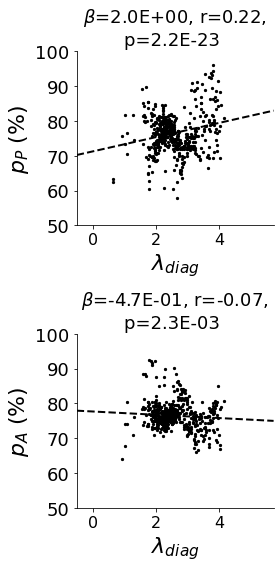

In [18]:
ylabels = [r'$p_P$ (%)', r'$p_A$ (%)']

Wrow1 = tf.stack([sW, vW, dW, hW], axis=1)
Wrow2 = tf.stack([vW, sW, hW, dW], axis=1)
Wrow3 = tf.stack([dW, hW, sW, vW], axis=1)
Wrow4 = tf.stack([hW, dW, vW, sW], axis=1)
W = tf.stack([Wrow1, Wrow2, Wrow3, Wrow4], axis=1)

eigs = np.array([get_schur_eigs(W[i]) for i in range(sW.shape[0])])
    
eig_names = ['all', 'side', 'task', 'diag']
eig_labels = [r'$\lambda_{%s}$' % eig_name for eig_name in eig_names]

#fig = pairplot(eigs[:num_plot], np.arange(4), eig_labels, outlier_stds=2,
#               fontsize=26, figsize=(10,10), ticksize=16, s=35, c=log_q_z_plot[:num_plot])

fig = pairplot(eigs[:num_plot], np.arange(4), eig_labels, outlier_stds=2,
               fontsize=26, figsize=(10,10), ticksize=16, s=35, c=100*pP, cmap=cmap_g)
plt.savefig(os.path.join(figdir, "SC_EPI_pP.png"))

fig = pairplot(eigs[:num_plot], np.arange(4), eig_labels, cmap=cmap_o, outlier_stds=2,
               fontsize=26, figsize=(10,10), ticksize=16, s=35, c=100*pA)
plt.savefig(os.path.join(figdir, "SC_EPI_pA.png"))

for i in range(4):
    plot_2corrs(eigs[:,i], eig_labels[i], 
                100*pP, 100*pA, ylabels, ylims=[50, 100],
                alignment='v', s=5, num_plot=500, fontsize=22)
    plt.tight_layout()
    #plt.savefig(os.path.join(figdir, "lambda_%s.pdf" % eig_names[i]), transparent=True)

74.0, 76.9


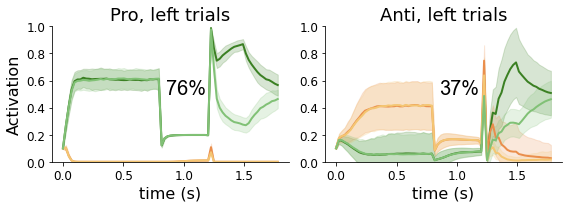

In [17]:
strength = 0.2
sc_sim_opto = SC_sim_opto(strength, 'delay')
u_t, v_t_stars = sc_sim_opto(*unwrap(z_stars))
T_x_stars = np.mean(expit(100.*(v_t_stars[-1,:,:,0,:] - v_t_stars[-1,:,:,3,:])), axis=2)

t_cue_delay = 1.2
t_choice = 0.3
t_post_choice = 0.3
t_total = t_cue_delay + t_choice + t_post_choice
dt = 0.024
t = np.arange(0.0, t_total, dt)
T = t.shape[0]

neuron_labels = ['LP', 'LA', 'RA', 'RP']
colors = [c_LP, c_LA, c_RA, c_RP]
C_titles = ['Pro, left trials', 'Anti, left trials',
            'Pro, left trials', 'Anti, left trials']
for m in range(len(z_stars)):
    print("%.1f, %.1f" % (100*T_x_stars[m,0], 100-100*T_x_stars[m,1]))
    fig, axs = plt.subplots(1,2,figsize=(8, 3))
    for c in range(2,4):
        for i in range(4):
            mean_v = np.mean(v_t_stars[:,m,c,i,:], axis=1)
            std_v = np.std(v_t_stars[:,m,c,i,:], axis=1)
            axs[c-2].fill_between(t, mean_v - std_v, mean_v + std_v, color=colors[i], alpha=0.2)
            axs[c-2].plot(t, mean_v, label=neuron_labels[i], c=colors[i])
            axs[c-2].set_title(C_titles[c])
            axs[c-2].set_ylim([0,1])
        axs[c-2].set_xlabel('time (s)')
        if c == 2:
            axs[c-2].text(0.85, 0.5, '%2d%%' % (100.*T_x_stars[m,c]), fontdict=percfont)
        else:
            axs[c-2].text(0.85, 0.5, '%2d%%' % (100.*(1.-T_x_stars[m,c])), fontdict=percfont)
        
    axs[0].set_ylabel('Activation')
        
    plt.tight_layout()
    #plt.savefig(os.path.join(figdir, "opto_sim%d.pdf" % (m+1)))
    plt.show()

In [61]:
def plot_corr(x, xlabel, y, ylabel, ylim=None, 
                 s=10, num_plot=None, c=None, fontsize=20):
    x_mean, x_std = np.mean(x) ,np.std(x)
    lin_model = scipy.stats.linregress(x, y)
    if c is None:
        c = 'k'
    xticksize = fontsize-6
    yticksize = fontsize-4
    titlesize = fontsize-4
    fig, ax = plt.subplots(1,1,figsize=(4,4))
    x = x[:num_plot]
    y = y[:num_plot]
    
    ax.scatter(x, y, s=s, c=c)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    plt.setp(ax.get_xticklabels(), fontsize=xticksize)
    plt.setp(ax.get_yticklabels(), fontsize=yticksize)
    
    x1, x2 = x_mean-3.5*x_std, x_mean+3.5*x_std
    ax.set_xlim([x1, x2])
    m, b, r, pval, _ = lin_model
    ax.plot([x1, x2], [b + m*x1, b+m*x2], 'k--')
    if pval < 0.05:
        pval_str = ""
    else:
        pval_str = "(n.s.)"
    metric_str = (r"$\beta$=%.1E, r=%.2f," "\n" "p=%.1E %s") % (m,r,pval,pval_str)
    ax.set_title(metric_str, fontsize=titlesize)
    if ylim is not None:
        ax.set_ylim(ylim)
        
    return None

In [19]:
strength = 0.2
sc_acc_diff = SC_acc_diff(strength, 'delay')
diffs = sc_acc_diff(*unwrap(z_plot)).numpy()
diffs[:,1] = -diffs[:,1]

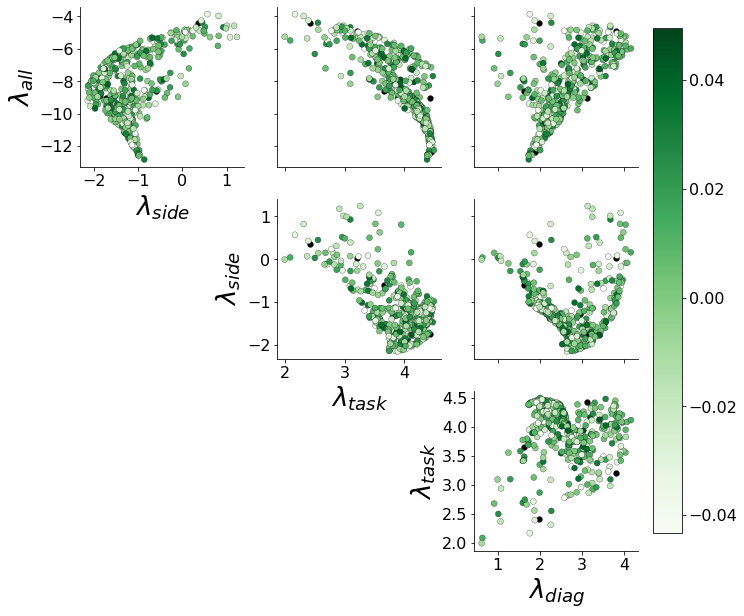

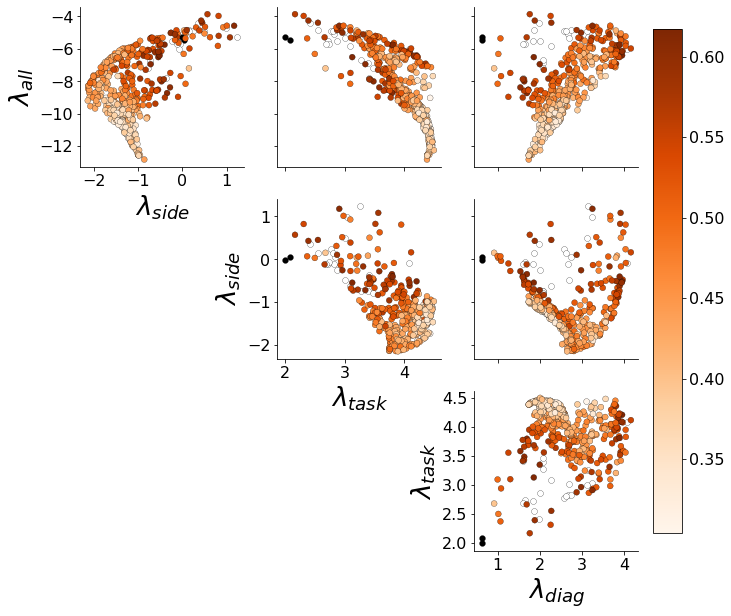

In [20]:
fig = pairplot(eigs[:num_plot], np.arange(4), eig_labels, outlier_stds=2,
               fontsize=26, figsize=(10,10), ticksize=16, s=35, c=diffs[:,0], cmap=cmap_g)

fig = pairplot(eigs[:num_plot], np.arange(4), eig_labels, cmap=cmap_o, outlier_stds=2,
               fontsize=26, figsize=(10,10), ticksize=16, s=35, c=diffs[:,1])

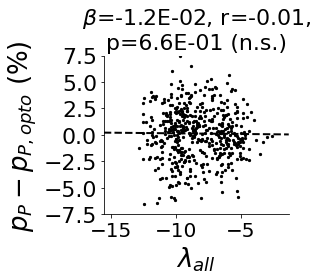

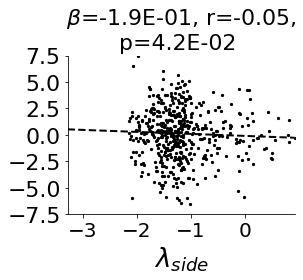

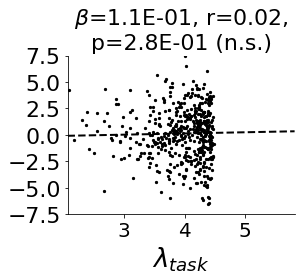

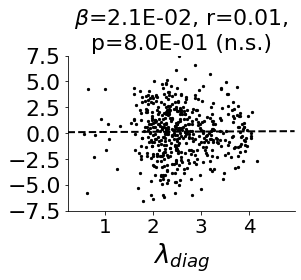

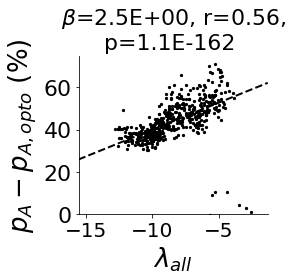

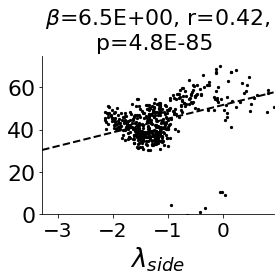

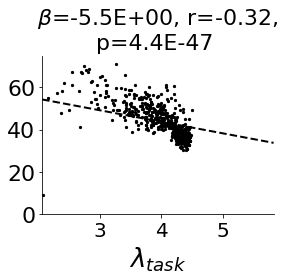

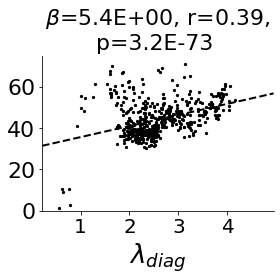

In [65]:
y_labels = [r'$p_P-p_{P,opto}$ (%)', r'$p_A-p_{A,opto}$ (%)']
tasks = ['P', 'A']
ylims = [[-7.5, 7.5], [0, 75]]
for j in range(2):
    ylim = ylims[j]
    for i, eig_name in enumerate(eig_names):
        if i==0:
            y_label = y_labels[j]
        else:
            y_label = ""
        plot_corr(eigs[:,i], r'$\lambda_{%s}$' % eig_name, 
                    100*diffs[:,j], y_label, ylim=ylim,
                    s=5, num_plot=500, fontsize=26)
        plt.tight_layout()
        #plt.savefig(os.path.join(figdir, "lambda_opto_%s_%s.pdf" % (eig_name, tasks[j])), 
        #            transparent=True)

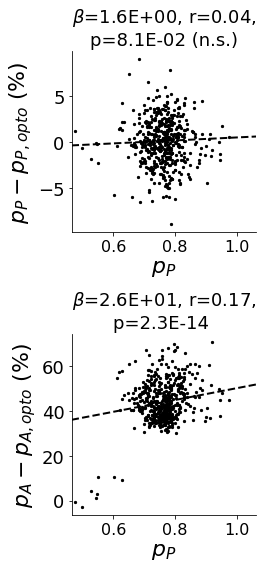

In [66]:
ylabels = [r'$p_P-p_{P,opto}$ (%)', r'$p_A-p_{A,opto}$ (%)']
plot_2corrs(pP, r'$p_P$', 100*diffs[:,0], 100*diffs[:,1], ylabels, 
             alignment='v', s=5, num_plot=500, fontsize=22)
plt.tight_layout()
#plt.savefig(os.path.join(figdir, "pP_opto.pdf"))

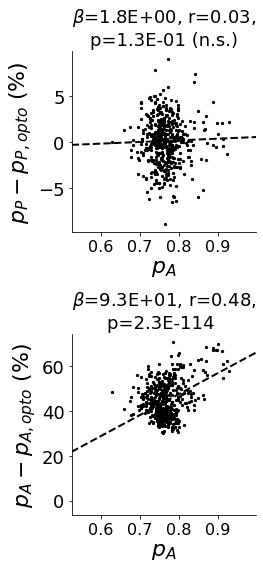

In [67]:
plot_2corrs(pA, r'$p_A$', 100*diffs[:,0], 100*diffs[:,1], ylabels,
             alignment='v', s=5, num_plot=500, fontsize=22)
plt.tight_layout()
#plt.savefig(os.path.join(figdir, "pA_opto.pdf"))

In [63]:
periods = ['delay', 'choice', 'total']
strengths = np.linspace(0., 1., 21)
diffs = []
approx_num = 100

for period in periods:
    _diffs = []
    for strength in strengths:
        print(period, strength)
        sc_acc_diff = SC_acc_diff(strength, period)
        _diff = sc_acc_diff(*unwrap(z_plot[:approx_num])).numpy()
        _diff[:,1] = -_diff[:,1]
        _diffs.append(_diff)
    diffs.append(np.array(_diffs))

delay 0.0
delay 0.05
delay 0.1
delay 0.15000000000000002
delay 0.2
delay 0.25
delay 0.30000000000000004
delay 0.35000000000000003
delay 0.4
delay 0.45
delay 0.5
delay 0.55
delay 0.6000000000000001
delay 0.65
delay 0.7000000000000001
delay 0.75
delay 0.8
delay 0.8500000000000001
delay 0.9
delay 0.9500000000000001
delay 1.0
choice 0.0
choice 0.05
choice 0.1
choice 0.15000000000000002
choice 0.2
choice 0.25
choice 0.30000000000000004
choice 0.35000000000000003
choice 0.4
choice 0.45
choice 0.5
choice 0.55
choice 0.6000000000000001
choice 0.65
choice 0.7000000000000001
choice 0.75
choice 0.8
choice 0.8500000000000001
choice 0.9
choice 0.9500000000000001
choice 1.0
total 0.0
total 0.05
total 0.1
total 0.15000000000000002
total 0.2
total 0.25
total 0.30000000000000004
total 0.35000000000000003
total 0.4
total 0.45
total 0.5
total 0.55
total 0.6000000000000001
total 0.65
total 0.7000000000000001
total 0.75
total 0.8
total 0.8500000000000001
total 0.9
total 0.9500000000000001
total 1.0


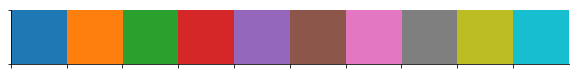

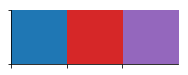

In [64]:
import seaborn as sns
pal = sns.color_palette()
sns.palplot(pal)
opto_colors = [pal[i] for i in [0, 3, 4]]
sns.palplot(opto_colors)

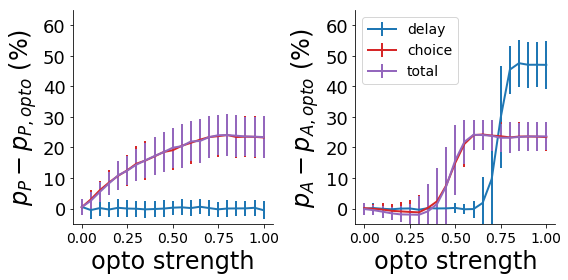

In [70]:
fig, axs = plt.subplots(1,2,figsize=(8,4))
for i, period in enumerate(periods):
    diff_mean = np.mean(100.*diffs[i], axis=1)
    diff_std = np.std(100.*diffs[i], axis=1)
    for j in range(2):
        axs[j].errorbar(1.-strengths, diff_mean[:,j], diff_std[:,j],
                        c=opto_colors[i], label=period)

fontsize = 24
ticksize = fontsize-10
for j in range(2):
    axs[j].set_xlabel('opto strength', fontsize=fontsize)
    axs[j].set_ylabel(ylabels[j], fontsize=fontsize)
    axs[j].set_ylim([-5, 65])
    plt.setp(axs[j].get_xticklabels(), fontsize=ticksize)
    plt.setp(axs[j].get_yticklabels(), fontsize=(ticksize+4))
axs[1].legend(fontsize=ticksize)
plt.tight_layout()
plt.savefig(os.path.join(figdir, "opto_effects.pdf"))